In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams.update({
    'figure.figsize': (3.6, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'legend.fontsize': 'small', 'axes.titlesize': 'medium',
    'axes.spines.top': False, 'axes.spines.right': False,
    'image.interpolation': 'nearest', 'savefig.dpi': 100,
})

import os
import torch
import pickle
from pathlib import Path
import numpy as np
from jarvis.utils import tqdm

from hexarena import STORE_DIR
FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)
rng = np.random.default_rng()

In [2]:
from hexarena.scripts.poisson_beliefs import create_manager

subject = 'marco'
manager = create_manager(subject)
manager.load_tar(STORE_DIR/f'{subject}.tar.gz')

Extracting files from tar:   0%|                                                                              …

Copying 'configs': 0file [00:00, ?file/s]

Copying 'stats': 0file [00:00, ?file/s]

Copying 'ckpts': 0file [00:00, ?file/s]

# Fetch valid blocks

Blocks using exponential schedule and quality cue are fetched.

In [3]:
from hexarena.utils import get_valid_blocks

block_infos = get_valid_blocks(subject, min_pos_ratio=0, min_gaze_ratio=0, min_push=10)
block_ids = [key for key in block_infos if block_infos[key]['gamma']==1]
print('{} blocks fetched'.format(len(block_ids)))

83 blocks fetched


In [47]:
session_id, block_idx = block_ids[5]
session_id, block_idx

('20211105', 6)

In [48]:
n_samples = 2000
cond = {
    'session_id': session_id, 'block_idx': block_idx,
    'tau_in_state': False, 'n_samples': n_samples,
}

In [49]:
probs = []
for key, config in manager.completed(cond=cond):
    manager.setup(config)
    n_steps = manager.load_ckpt(manager.ckpts[key])
    beliefs = torch.stack(manager.beliefs)
    probs.append(torch.softmax(beliefs.reshape(-1, 3, 2), dim=2)[..., 0])
probs = torch.stack(probs)
print('{} random seeds complete'.format(len(probs)))

3 random seeds complete


In [50]:
colors = []
for box in manager.model.env.boxes:
    if box.tau==15:
        colors.append('red')
    if box.tau==21:
        colors.append('orange')
    if box.tau==35:
        colors.append('blue')

In [51]:
p_mean = probs.mean(dim=0)
p_std = probs.std(dim=0)

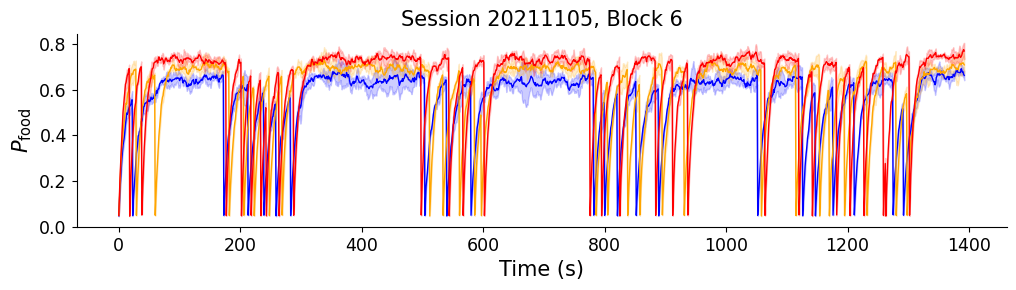

In [52]:
_, ax = plt.subplots(figsize=(12, 2.5))
for i, color in enumerate(colors):
    ax.plot(np.arange(n_steps+1), p_mean[:, i], color, linewidth=1)
    ax.fill_between(np.arange(n_steps+1), p_mean[:, i]-p_std[:, i], p_mean[:, i]+p_std[:, i], color=color, alpha=0.2)
ax.set_xlabel('Time (s)')
# ax.set_xlim([0, 360])
ax.set_ylabel(r'$P_\mathrm{food}$')
ax.set_ylim([0, None])
ax.set_title('Session {}, Block {}'.format(session_id, block_idx))
plt.show()

# Prepare inputs for HMP training

In [53]:
inputs = probs[0][:-1]
actions = torch.tensor(manager.actions, dtype=torch.long)

print('Policy input dimension: {}'.format(inputs.shape[1]))

Policy input dimension: 3


In [55]:
from irc.hmp import HiddenMarkovePolicy

n_policies = 2
hmp = HiddenMarkovePolicy(
    n_policies, 3, 4,
)

gammas, Ps, As, losses = hmp.learn(inputs, actions, n_iters=150, alpha_P=10, alpha_A=10, ent_reg=0.01, n_epochs=200)

EM algorithm:   0%|                                                                                           …

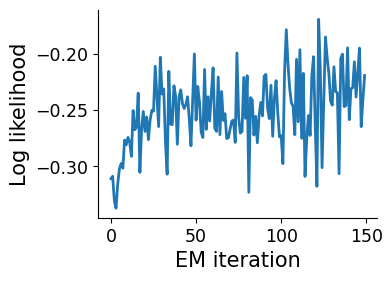

In [58]:
_, ax = plt.subplots()
ax.plot(-losses[:, 2])
ax.set_xlabel('EM iteration')
ax.set_ylabel('Log likelihood')
plt.show()

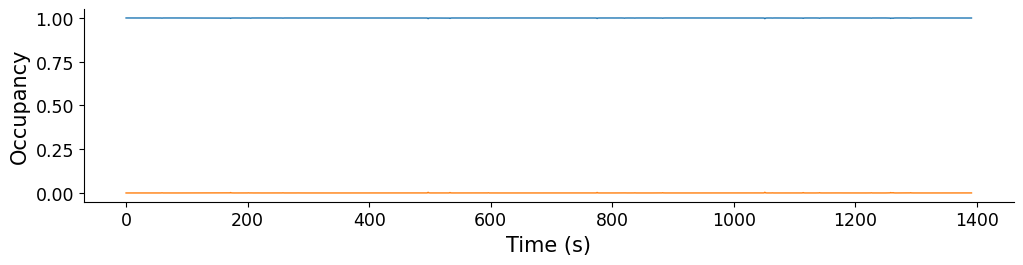

In [59]:
_, ax = plt.subplots(figsize=(12, 2.5))
ax.plot(gammas[-1], linewidth=1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Occupancy')
plt.show()

# Training for all blocks

In [46]:
n_samples = 2000
cond = {
    'tau_in_state': False, 'n_samples': n_samples,
}
inputs, actions, keys = [], [], []
for key, config in manager.completed(cond=cond):
    manager.setup(config)
    n_steps = manager.load_ckpt(manager.ckpts[key])
    beliefs = torch.stack(manager.beliefs)
    inputs.append(torch.softmax(beliefs.reshape(-1, 3, 2), dim=2)[:-1, :, 0])
    actions.append(torch.tensor(manager.actions, dtype=torch.long))
    keys.append(key)

In [47]:
n_policies = 3
hmp = HiddenMarkovePolicy(
    n_policies, 3, 4,
)

gammas, Ps, As, losses = hmp.learn(inputs, actions, n_iters=10, alpha_P=10, alpha_A=10)

EM algorithm:   0%|                                                                                           …

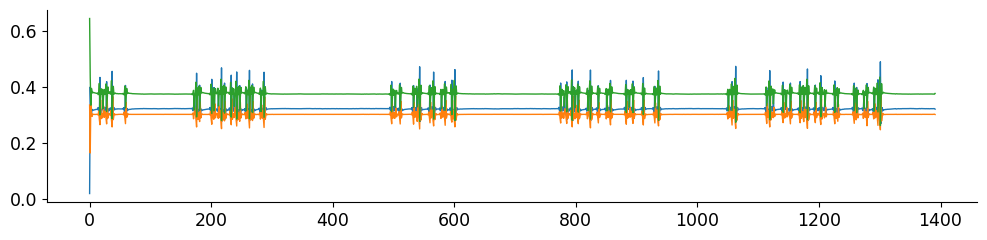

In [50]:
_, ax = plt.subplots(figsize=(12, 2.5))
ax.plot(gammas[0][-1], linewidth=1)
plt.show()